In [4]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from gym import utils
import gym
import pickle

### MLens Dataset Loading & Preparation

In [5]:
# Loading the MovieLens dataset
ML_LATEST_SMALL_DATA_ROOT_PATH = "../data/dt-datasets/movielens/ml-latest-small"
ML_LATEST_DATA_ROOT_PATH = "../data/dt-datasets/movielens/ml-latest"

##### Load the ML-latest-small dataset

In [6]:
links_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "links.csv"))
movies_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "ratings.csv"))
tags_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "tags.csv"))
print(f"links shape: {links_df.shape}\nmovies shape: {movies_df.shape}\nratings shape: {ratings_df.shape}\ntags shape: {tags_df.shape}")

links shape: (9742, 3)
movies shape: (9742, 3)
ratings shape: (100836, 4)
tags shape: (3683, 4)


##### Load the ML-latest-full dataset

In [7]:
# links_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "links.csv"))
# movies_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "movies.csv"))
# ratings_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "ratings.csv"))
# tags_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "tags.csv"))
# print(f"links shape: {links_25m_df.shape}\nmovies shape: {movies_25m_df.shape}\nratings shape: {ratings_25m_df.shape}\ntags shape: {tags_25m_df.shape}")

min no of rating: 20, max no of rating: 2698
average rating per user: 165.30491803278687, median rating per user: 70.5
number of users who rated less than 140 movies: 429


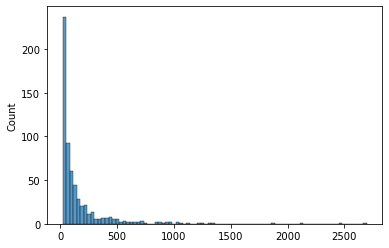

In [8]:
# Data distribution of the rating count per user in the small dataset
rating_count_per_user = ratings_df.groupby('userId')['movieId'].count().values
print(f'min no of rating: {np.min(rating_count_per_user)}, max no of rating: {np.max(rating_count_per_user)}')
print(f'average rating per user: {np.mean(rating_count_per_user)}, median rating per user: {np.median(rating_count_per_user)}')
print(f'number of users who rated less than 140 movies: {(rating_count_per_user <= 140).sum()}')
sns.histplot(data = rating_count_per_user)
plt.show()
# sns.boxplot(rating_count_per_user)

In [9]:
# # Data distribution of the rating count per user in the large dataset
# rating_count_per_user = ratings_25m_df.groupby('userId')['movieId'].count().values
# print(f'min no of rating: {np.min(rating_count_per_user)}, max no of rating: {np.max(rating_count_per_user)}')
# print(f'average rating per user: {np.mean(rating_count_per_user)}, median rating per user: {np.median(rating_count_per_user)}')

# rating_count_less_than_140 = (rating_count_per_user <= 140).sum()
# print(f'number of users who rated less than 140 movies: {rating_count_less_than_140} which is {(rating_count_less_than_140 / ratings_25m_df.userId.unique().shape[0]) * 100}% of the users.')
# sns.histplot(data = rating_count_per_user, bins=100)
# plt.show()
# # sns.boxplot(rating_count_per_user)

##### Prepare the movies_df

In [10]:
print(movies_df['title'].unique().shape[0])

# Find the duplicated movie titles
duplicated_movies = movies_df[movies_df['title'].duplicated(keep=False)].sort_values(by=['title', 'movieId'])

# Some movies have additional genres, that's why the duplicates
# Merge the genres, keep the ID of the one that has the highest number
# of genres, create a map of the old and new id
# drop the row with the least genre after merging
duplicated_movie_titles = duplicated_movies['title'].unique()
movie_ids_to_remove = duplicated_movies['movieId'].values
movie_indices_to_remove = duplicated_movies.index.values
id_mapping = {}
resolved_movies = []
for title in duplicated_movie_titles:
    movie_ids = duplicated_movies[duplicated_movies['title'] == title]['movieId'].values
    genre_groups = duplicated_movies[duplicated_movies['title'] == title]['genres'].values

    for i in range(1, len(movie_ids)):
        id_mapping[movie_ids[i]] = movie_ids[0]
    merged_genres = set()
    for genre_grp in genre_groups:
        genres = genre_grp.split('|')
        merged_genres = merged_genres.union(set(genres))
    merged_genres = list(merged_genres)
    genres_mixed = ""
    for (i, g) in enumerate(merged_genres):
        if i != len(merged_genres)-1:
            genres_mixed += g + "|"
        else:
            genres_mixed += g

    resolved_movies.append({'movieId': movie_ids[0], 'title': title, 'genres': genres_mixed})

pd.DataFrame(resolved_movies)


9737


,movieId,title,genres
0,6003,Confessions of a Dangerous Mind (2002),Thriller|Romance|Drama|Comedy|Crime
1,838,Emma (1996),Romance|Drama|Comedy
2,32600,Eros (2004),Romance|Drama
3,2851,Saturn 3 (1980),Sci-Fi|Thriller|Adventure
4,34048,War of the Worlds (2005),Action|Sci-Fi|Thriller|Adventure


In [11]:
# Now remove the duplicate movies from the movies_df
print(f"Shape before rmeoving: {movies_df.shape}")
movies_df = movies_df.drop(movie_indices_to_remove)
print(f"Shape after rmeoving: {movies_df.shape}")

Shape before rmeoving: (9742, 3)
Shape after rmeoving: (9732, 3)


In [12]:
# Now concatenate the movies_df with removed movies and the merged_genres movies
movies_df = pd.concat([movies_df, pd.DataFrame(resolved_movies)], ignore_index=True)
print(movies_df.shape)

(9737, 3)


##### Prepare the ratings_df

In [13]:
# Now we have to replace the removed movie ids in the ratings_df
# and also in the tags_df
ratings_df.head()
ratings_df_copy = ratings_df.copy()

In [14]:
# Replace the ids with the id_mapping
ratings_df_copy['movieId'] = ratings_df_copy['movieId'].replace(id_mapping)

In [15]:
# See the duplicates
ratings_df_copy[ratings_df_copy[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,rating,timestamp
4590,28,34048,3.5,1234516420
4747,28,34048,3.5,1234850075
11241,68,34048,2.0,1158532246
11451,68,34048,2.5,1230497715
17449,111,6003,4.0,1516468531
17819,111,6003,4.0,1517441257
80405,509,838,3.5,1436031723
80596,509,838,3.5,1436031753


In [16]:
ratings_df_copy = ratings_df_copy.drop_duplicates(['userId', 'movieId', 'rating'])

In [17]:
# Only one movie with two different ratings from the same user
ratings_df_copy[ratings_df_copy[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,rating,timestamp
11241,68,34048,2.0,1158532246
11451,68,34048,2.5,1230497715


In [18]:
# We will drop the one with the lowest rating
ratings_df = ratings_df_copy.drop([11241])
ratings_df.shape

(100832, 4)

In [19]:
# no more duplicates
ratings_df[ratings_df[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,rating,timestamp


##### Prepare the tags_df

In [20]:
# Now we have to replace the removed movie ids in the tags_df
tags_df_copy = tags_df.copy()
tags_df_copy.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [21]:
# Replace the ids first with the id_mapping
tags_df_copy['movieId'] = tags_df_copy['movieId'].replace(id_mapping)

In [22]:
# See the duplicates
tags_df_copy[tags_df_copy[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3669,599,2959,twist ending,1498456888
3670,599,2959,violence,1498456904
3671,599,2959,violent,1498456914
3680,610,3265,gun fu,1493843984


In [23]:
# Results suggest that there are some outliers in the dataset
tags_df_copy.groupby(['userId'])['movieId'].count().mean(), tags_df_copy.groupby(['userId'])['movieId'].count().median()

(63.5, 4.0)

In [24]:
# Average number of tags per user per movie
tags_df_copy.groupby(['userId', 'movieId']).count()['tag'].mean()

2.074929577464789

In [25]:
# Outlier: user 599 provided 173 tags for the movie 296
print(f"name of the movie: {movies_df[movies_df['movieId'] == 296]['title'].values[0]}")
tags_df[(tags_df['userId'] == 599) & (tags_df['movieId'] == 296)].sort_values(by='timestamp')

name of the movie: Pulp Fiction (1994)


,userId,movieId,tag,timestamp
3512,599,296,Quentin Tarantino,1498456338
3425,599,296,dark comedy,1498456339
3495,599,296,nonlinear,1498456341
3528,599,296,Samuel L. Jackson,1498456342
3490,599,296,multiple storylines,1498456343
...,...,...,...,...
3526,599,296,Roger Avary,1498456682
3460,599,296,Harvey Keitel,1498456684
3445,599,296,foul language,1498456686
3506,599,296,Palme d'Or,1498456690


##### Merge the tags

In [26]:
# tags_df['tag'] = tags_df['tag'].str.lower()
tags_df['tag'] = tags_df['tag'].str.lower().astype(str)

# Grouping by 'movieId' and 'userId' and aggregating tags
tags_df_merged = tags_df.groupby(['movieId', 'userId'])['tag'].agg(lambda x: '|'.join(x)).reset_index()
tags_df_merged

,movieId,userId,tag
0,1,336,pixar
1,1,474,pixar
2,1,567,fun
3,2,62,fantasy|magic board game|robin williams
4,2,474,game
...,...,...,...
1770,183611,62,comedy|funny|rachel mcadams
1771,184471,62,adventure|alicia vikander|video game adaptation
1772,187593,62,josh brolin|ryan reynolds|sarcasm
1773,187595,62,emilia clarke|star wars


##### Merge the movies and ratings dataframes together

In [27]:
movies_and_ratings = pd.merge(movies_df, ratings_df, on='movieId')
movies_and_ratings.shape

(100832, 6)

In [28]:
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [29]:
# Check if there is any duplicate
print(movies_and_ratings.duplicated().sum())

print(movies_and_ratings.isna().sum())
movies_and_ratings[movies_and_ratings[['movieId', 'userId']].duplicated(keep=False)]

0
movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


,movieId,title,genres,userId,rating,timestamp


In [30]:
movies_and_ratings.dtypes

movieId        int64
title         object
genres        object
userId         int64
rating       float64
timestamp      int64
dtype: object

In [31]:
# Check if there are any null values
movies_and_ratings['userId'].isna().sum(),  movies_and_ratings['movieId'].isna().sum()

(0, 0)

In [32]:
# Check if all the userIds are present in the merged df as well
sorted(ratings_df.userId.unique()) ==  sorted(movies_and_ratings.userId.unique())

True

In [33]:
# Sort the movie ratings by userId and timestamp in an ascending manner
movies_and_ratings = movies_and_ratings.sort_values(by=['userId', 'timestamp'])
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
19452,804,She's the One (1996),Comedy|Romance,1,4.0,964980499
25835,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1,5.0,964980499
38331,2018,Bambi (1942),Animation|Children|Drama,1,5.0,964980523
45777,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,1,4.0,964980523
48477,2826,"13th Warrior, The (1999)",Action|Adventure|Fantasy,1,4.0,964980523


In [34]:
# Find out the different rating values
sorted(movies_and_ratings['rating'].unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

#### How many different genres do we have?

In [61]:
all_genres = np.unique(np.concatenate(movies_and_ratings['genres'].apply(lambda g: g.split("|")).tolist()))

In [36]:
# all_genres = movies_and_ratings['genres']

## Personal Embeddings

1. Which genre the user rated the most
2. Average rating of the user
3. Average rating per genre
4. Last 10 ratings
5. Last 10 rated movies
6. Which genre of movies does the user like the most?
7. Number of rated movies per genres
8. Average Rating per genre
9. Total genres rated



The Movielens dataset can be used to create a variety of personal features for movie recommendation to users. These features can be used to capture the specific interests and preferences of individual users. Here are some examples of personal features that can be created from the Movielens dataset:

**Genre preferences:**

* **Top genres:** Identify the genres of movies that a user has rated highly in the past.

* **Genre diversity:** Measure the diversity of genres in a user's ratings. This can be used to identify users who are open to trying new genres.

* **Genre consistency:** Calculate the consistency of a user's genre preferences. This can be used to identify users who have strong preferences for specific genres.

**Director preferences:**

* **Top directors:** Identify the directors of movies that a user has rated highly in the past.

* **Director diversity:** Measure the diversity of directors in a user's ratings. This can be used to identify users who are open to watching movies by new directors.

* **Director consistency:** Calculate the consistency of a user's director preferences. This can be used to identify users who have strong preferences for specific directors.

**Actor preferences:**

* **Top actors:** Identify the actors in movies that a user has rated highly in the past.

* **Actor diversity:** Measure the diversity of actors in a user's ratings. This can be used to identify users who are open to watching movies with new actors.

* **Actor consistency:** Calculate the consistency of a user's actor preferences. This can be used to identify users who have strong preferences for specific actors.

**Rating tendencies:**

* **Average rating:** Calculate the average rating that a user has given to movies in the past.

* **Rating variability:** Measure the variability of a user's ratings. This can be used to identify users who are consistent in their ratings and users who are more open to giving extremes.

* **Rating biases:** Identify any biases in a user's ratings, such as a tendency to give higher ratings to movies with specific genres or actors.

**Temporal patterns:**

* **Rating frequency:** Measure the frequency with which a user rates movies. This can be used to identify users who are more active in rating movies.

* **Rating trends:** Identify any trends in a user's ratings over time, such as a shift in preferences or a decrease in activity.

* **Seasonality:** Analyze whether a user's ratings are influenced by seasons or holidays.

By creating these personal features, you can develop a more personalized movie recommendation system that takes into account the specific interests and preferences of individual users. This can lead to more engaging and relevant recommendations for your users.

In [222]:
# Group the data by user
grouped_df = movies_and_ratings.groupby('userId')

In [235]:
# Extract the genres for each movie for each user
per_user_genre_counts = {}
all_genre_count_dict = {f'{genre}_count': 0 for genre in all_genres}

for user_id, user_df in grouped_df:
    user_df['genres_splitted'] = user_df['genres'].str.split('|')
    genre_counts = all_genre_count_dict.copy()

    # Create separate columns for each genre
    for genres, rating in zip(user_df['genres_splitted'], ratings):
        for gen in genres:
            if f'{gen}_count' in genre_counts:
                genre_counts[f'{gen}_count'] += 1
            else:
                genre_counts[f'{gen}_count'] = 1

    
    per_user_genre_counts[user_id] = genre_counts

# Extract the genres for each movie for each user
per_user_genre_rating_sum = {}
all_genre_rating_sum_dict = {f'{genre}_rating_sum': 0 for genre in all_genres}
for user_id, user_df in grouped_df:
    user_df['genres_splitted'] = user_df['genres'].str.split('|')
    ratings = user_df['rating'].tolist()

    genre_rating_sums = all_genre_rating_sum_dict.copy()

    # Create separate columns for each genre
    for genres, rating in zip(user_df['genres_splitted'], ratings):
        for gen in genres:
            if f'{gen}_rating_sum' in genre_rating_sums:
                genre_rating_sums[f'{gen}_rating_sum'] += rating
            else:
                genre_rating_sums[f'{gen}_rating_sum'] = rating

    per_user_genre_rating_sum[user_id] = genre_rating_sums



In [236]:
# Find the most rated genres per user
most_rated_genre_per_user = {}
per_user_genre_counts_copy = per_user_genre_counts.copy()
for user_id in per_user_genre_counts_copy:
    genre_counts = per_user_genre_counts_copy[user_id]
    most_rated_genre_with_count = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[0]
    # print(most_rated_genre_with_count)
    most_rated_genre = most_rated_genre_with_count[0].split('_')[0]
    # print(most_rated_genre)
    most_rated_genre_per_user[user_id] = most_rated_genre
most_rated_genre_per_user



{1: 'Action',
 2: 'Drama',
 3: 'Drama',
 4: 'Drama',
 5: 'Drama',
 6: 'Drama',
 7: 'Action',
 8: 'Comedy',
 9: 'Drama',
 10: 'Comedy',
 11: 'Action',
 12: 'Romance',
 13: 'Drama',
 14: 'Drama',
 15: 'Action',
 16: 'Drama',
 17: 'Drama',
 18: 'Drama',
 19: 'Comedy',
 20: 'Children',
 21: 'Action',
 22: 'Drama',
 23: 'Drama',
 24: 'Action',
 25: 'Action',
 26: 'Thriller',
 27: 'Adventure',
 28: 'Drama',
 29: 'Drama',
 30: 'Action',
 31: 'Comedy',
 32: 'Drama',
 33: 'Drama',
 34: 'Action',
 35: 'Comedy',
 36: 'Drama',
 37: 'Thriller',
 38: 'Comedy',
 39: 'Drama',
 40: 'Drama',
 41: 'Drama',
 42: 'Comedy',
 43: 'Comedy',
 44: 'Comedy',
 45: 'Comedy',
 46: 'Action',
 47: 'Drama',
 48: 'Action',
 49: 'Drama',
 50: 'Drama',
 51: 'Comedy',
 52: 'Action',
 53: 'Drama',
 54: 'Drama',
 55: 'Drama',
 56: 'Action',
 57: 'Comedy',
 58: 'Drama',
 59: 'Drama',
 60: 'Drama',
 61: 'Drama',
 62: 'Action',
 63: 'Comedy',
 64: 'Drama',
 65: 'Drama',
 66: 'Drama',
 67: 'Action',
 68: 'Comedy',
 69: 'Drama',

In [237]:
most_rated_genre_per_user_df = pd.DataFrame(most_rated_genre_per_user.items(), columns=['userId', 'most_rated_genre'])
most_rated_genre_per_user_df['most_rated_genre'].value_counts()

Drama        279
Comedy       158
Action       116
Adventure     24
Thriller      20
Horror         4
Romance        3
Sci-Fi         2
Crime          1
Animation      1
Fantasy        1
Children       1
Name: most_rated_genre, dtype: int64

In [238]:
# Highest, lowest and average rating per user
stat_feat_per_user = []
for user_id, user_df in grouped_df:
    highest_rating = user_df['rating'].max()
    lowest_rating = user_df['rating'].min()
    average_rating = user_df['rating'].mean()
    stat_feat_per_user.append({'userId': user_id, 'highest_rating': highest_rating, 'lowest_rating': lowest_rating, 'avg_rating': average_rating})
statistical_features_df = pd.DataFrame(stat_feat_per_user)
statistical_features_df

,userId,highest_rating,lowest_rating,avg_rating
0,1,5.0,1.0,4.366379
1,2,5.0,2.0,3.948276
2,3,5.0,0.5,2.435897
3,4,5.0,1.0,3.555556
4,5,5.0,1.0,3.636364
...,...,...,...,...
605,606,5.0,0.5,3.657399
606,607,5.0,1.0,3.786096
607,608,5.0,0.5,3.134176
608,609,4.0,3.0,3.270270


In [244]:
per_user_avg_genre_ratings = []
avg_genre_rating_init = {f'{genre}_avg_rating': 0 for genre in all_genres}
# all_genre_count_dict = {f'{genre}_count': 0 for genre in all_genres}
for user_id in per_user_genre_rating_sum:
    avg_genre_rating = avg_genre_rating_init.copy()
    # print(f"user_id: {user_id}")
    genre_counts_per_user = per_user_genre_counts[user_id].copy()
    genre_rating_sums_per_user = per_user_genre_rating_sum[user_id].copy()
    for genre in all_genres:
        if genre_counts_per_user[f'{genre}_count'] == 0:
            avg_genre_rating[f'{genre}_avg_rating'] = 0
        else:
            avg_genre_rating[f'{genre}_avg_rating'] = genre_rating_sums_per_user[f'{genre}_rating_sum'] / genre_counts_per_user[f'{genre}_count']

    avg_genre_rating['userId'] = user_id
    print(avg_genre_rating)
    per_user_avg_genre_ratings.append(avg_genre_rating)


{'(no genres listed)_avg_rating': 0, 'Action_avg_rating': 4.322222222222222, 'Adventure_avg_rating': 4.3882352941176475, 'Animation_avg_rating': 4.689655172413793, 'Children_avg_rating': 4.5476190476190474, 'Comedy_avg_rating': 4.27710843373494, 'Crime_avg_rating': 4.355555555555555, 'Documentary_avg_rating': 0, 'Drama_avg_rating': 4.529411764705882, 'Fantasy_avg_rating': 4.297872340425532, 'Film-Noir_avg_rating': 5.0, 'Horror_avg_rating': 3.4705882352941178, 'IMAX_avg_rating': 0, 'Musical_avg_rating': 4.681818181818182, 'Mystery_avg_rating': 4.166666666666667, 'Romance_avg_rating': 4.3076923076923075, 'Sci-Fi_avg_rating': 4.225, 'Thriller_avg_rating': 4.1454545454545455, 'War_avg_rating': 4.5, 'Western_avg_rating': 4.285714285714286, 'userId': 1}
{'(no genres listed)_avg_rating': 0, 'Action_avg_rating': 3.9545454545454546, 'Adventure_avg_rating': 4.166666666666667, 'Animation_avg_rating': 0, 'Children_avg_rating': 0, 'Comedy_avg_rating': 4.0, 'Crime_avg_rating': 3.8, 'Documentary_avg_

In [245]:
from copy import deepcopy
most_liked_genres_per_user = {}
per_user_avg_genre_ratings_copy = deepcopy(per_user_avg_genre_ratings)
for dictt in per_user_avg_genre_ratings_copy:
    user_id = dictt['userId']
    dictt.pop('userId')
    most_liked_genre = sorted(dictt.items(), key=lambda x: x[1], reverse=True)[0][0].split('_')[0]
    print(most_liked_genre)
    most_liked_genres_per_user[user_id] = most_liked_genre
most_liked_genres_per_user


Film-Noir
Romance
Mystery
Horror
Musical
IMAX
Horror
Animation
Fantasy
Animation
Horror
Romance
Mystery
Mystery
War
IMAX
War
Western
Film-Noir
IMAX
(no genres listed)
Film-Noir
Mystery
Animation
Crime
Horror
Mystery
IMAX
Film-Noir
Drama
Documentary
Crime
Film-Noir
Adventure
Mystery
Film-Noir
Horror
Documentary
Horror
IMAX
Film-Noir
IMAX
Animation
Crime
IMAX
Animation
War
Fantasy
Action
Film-Noir
Documentary
Musical
Action
Horror
Crime
Animation
Film-Noir
Mystery
Horror
IMAX
Mystery
(no genres listed)
Film-Noir
War
IMAX
IMAX
War
IMAX
Fantasy
Children
Animation
Crime
War
Documentary
IMAX
Horror
Animation
IMAX
Film-Noir
Mystery
Mystery
War
Musical
IMAX
Adventure
Mystery
Animation
Fantasy
Documentary
Crime
Animation
Fantasy
IMAX
Animation
Animation
Animation
Fantasy
War
Animation
IMAX
Drama
Animation
Film-Noir
Film-Noir
(no genres listed)
Crime
IMAX
Musical
War
Documentary
Documentary
Mystery
War
Horror
Western
Western
IMAX
Drama
Musical
Crime
Crime
Film-Noir
Western
Drama
(no genres liste

{1: 'Film-Noir',
 2: 'Romance',
 3: 'Mystery',
 4: 'Horror',
 5: 'Musical',
 6: 'IMAX',
 7: 'Horror',
 8: 'Animation',
 9: 'Fantasy',
 10: 'Animation',
 11: 'Horror',
 12: 'Romance',
 13: 'Mystery',
 14: 'Mystery',
 15: 'War',
 16: 'IMAX',
 17: 'War',
 18: 'Western',
 19: 'Film-Noir',
 20: 'IMAX',
 21: '(no genres listed)',
 22: 'Film-Noir',
 23: 'Mystery',
 24: 'Animation',
 25: 'Crime',
 26: 'Horror',
 27: 'Mystery',
 28: 'IMAX',
 29: 'Film-Noir',
 30: 'Drama',
 31: 'Documentary',
 32: 'Crime',
 33: 'Film-Noir',
 34: 'Adventure',
 35: 'Mystery',
 36: 'Film-Noir',
 37: 'Horror',
 38: 'Documentary',
 39: 'Horror',
 40: 'IMAX',
 41: 'Film-Noir',
 42: 'IMAX',
 43: 'Animation',
 44: 'Crime',
 45: 'IMAX',
 46: 'Animation',
 47: 'War',
 48: 'Fantasy',
 49: 'Action',
 50: 'Film-Noir',
 51: 'Documentary',
 52: 'Musical',
 53: 'Action',
 54: 'Horror',
 55: 'Crime',
 56: 'Animation',
 57: 'Film-Noir',
 58: 'Mystery',
 59: 'Horror',
 60: 'IMAX',
 61: 'Mystery',
 62: '(no genres listed)',
 63: 'F

In [247]:
per_user_avg_genre_ratings

[{'(no genres listed)_avg_rating': 0,
  'Action_avg_rating': 4.322222222222222,
  'Adventure_avg_rating': 4.3882352941176475,
  'Animation_avg_rating': 4.689655172413793,
  'Children_avg_rating': 4.5476190476190474,
  'Comedy_avg_rating': 4.27710843373494,
  'Crime_avg_rating': 4.355555555555555,
  'Documentary_avg_rating': 0,
  'Drama_avg_rating': 4.529411764705882,
  'Fantasy_avg_rating': 4.297872340425532,
  'Film-Noir_avg_rating': 5.0,
  'Horror_avg_rating': 3.4705882352941178,
  'IMAX_avg_rating': 0,
  'Musical_avg_rating': 4.681818181818182,
  'Mystery_avg_rating': 4.166666666666667,
  'Romance_avg_rating': 4.3076923076923075,
  'Sci-Fi_avg_rating': 4.225,
  'Thriller_avg_rating': 4.1454545454545455,
  'War_avg_rating': 4.5,
  'Western_avg_rating': 4.285714285714286,
  'userId': 1},
 {'(no genres listed)_avg_rating': 0,
  'Action_avg_rating': 3.9545454545454546,
  'Adventure_avg_rating': 4.166666666666667,
  'Animation_avg_rating': 0,
  'Children_avg_rating': 0,
  'Comedy_avg_rat

In [248]:
most_liked_genres_per_user_df = pd.DataFrame(list(most_liked_genres_per_user.items()), columns=['userId', 'most_liked_genre'])
most_liked_genres_per_user_df

,userId,most_liked_genre
0,1,Film-Noir
1,2,Romance
2,3,Mystery
3,4,Horror
4,5,Musical
...,...,...
605,606,Film-Noir
606,607,IMAX
607,608,IMAX
608,609,Western


In [249]:
per_user_genre_avg_df = pd.DataFrame(per_user_avg_genre_ratings)
per_user_genre_avg_df

,(no genres listed)_avg_rating,Action_avg_rating,Adventure_avg_rating,Animation_avg_rating,Children_avg_rating,Comedy_avg_rating,Crime_avg_rating,Documentary_avg_rating,Drama_avg_rating,Fantasy_avg_rating,...,Horror_avg_rating,IMAX_avg_rating,Musical_avg_rating,Mystery_avg_rating,Romance_avg_rating,Sci-Fi_avg_rating,Thriller_avg_rating,War_avg_rating,Western_avg_rating,userId
0,0.0,4.322222,4.388235,4.689655,4.547619,4.277108,4.355556,0.000000,4.529412,4.297872,...,3.470588,0.000000,4.681818,4.166667,4.307692,4.225000,4.145455,4.500000,4.285714,1
1,0.0,3.954545,4.166667,0.000000,0.000000,4.000000,3.800000,4.333333,3.882353,0.000000,...,3.000000,3.750000,0.000000,4.000000,4.500000,3.875000,3.700000,4.500000,3.500000,2
2,0.0,3.571429,2.727273,0.500000,0.500000,1.000000,0.500000,0.000000,0.750000,3.375000,...,4.687500,0.000000,0.500000,5.000000,0.500000,4.200000,4.142857,0.500000,0.000000,3
3,0.0,3.320000,3.655172,4.000000,3.800000,3.509615,3.814815,4.000000,3.483333,3.684211,...,4.250000,3.000000,4.000000,3.478261,3.379310,2.833333,3.552632,3.571429,3.800000,4
4,0.0,3.111111,3.250000,4.333333,4.111111,3.466667,3.833333,0.000000,3.800000,4.142857,...,3.000000,3.666667,4.400000,4.000000,3.090909,2.500000,3.555556,3.333333,3.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.0,3.178808,3.503401,3.714286,3.448980,3.565321,3.654135,3.800000,3.787966,3.597938,...,3.346154,3.062500,3.727273,3.791209,3.740169,3.556962,3.525126,3.792308,3.411765,606
606,0.0,3.722222,3.466667,3.333333,3.421053,3.327273,3.814815,0.000000,4.012195,3.571429,...,4.114286,5.000000,3.600000,4.647059,3.517241,3.250000,4.114754,4.166667,4.000000,607
607,0.0,3.330325,3.220994,3.118182,2.460227,2.736620,3.613014,3.000000,3.437500,3.000000,...,3.319588,4.000000,2.757576,3.550725,2.901869,3.296407,3.536680,3.578947,2.636364,608
608,0.0,3.090909,3.200000,3.000000,3.000000,3.285714,3.500000,3.000000,3.368421,3.000000,...,3.500000,3.000000,0.000000,0.000000,3.200000,3.000000,3.285714,3.500000,4.000000,609


In [250]:
genre_counts_per_user = []
per_user_genre_counts_copy = per_user_genre_counts.copy()
for user_id in per_user_genre_counts_copy:
    genre_counts = per_user_genre_counts_copy[user_id]
    genre_counts['userId'] = user_id
    genre_counts_per_user.append(genre_counts)

In [251]:
genre_counts_per_user_df = pd.DataFrame(genre_counts_per_user)
genre_counts_per_user_df

,(no genres listed)_count,Action_count,Adventure_count,Animation_count,Children_count,Comedy_count,Crime_count,Documentary_count,Drama_count,Fantasy_count,...,Horror_count,IMAX_count,Musical_count,Mystery_count,Romance_count,Sci-Fi_count,Thriller_count,War_count,Western_count,userId
0,0,90,85,29,42,83,45,0,68,47,...,17,0,22,18,26,40,55,22,7,1
1,0,11,3,0,0,7,10,3,17,0,...,1,4,0,2,1,4,10,1,1,2
2,0,14,11,4,5,9,2,0,16,4,...,8,0,1,1,5,15,7,5,0,3
3,0,25,29,6,10,104,27,2,120,19,...,4,1,16,23,58,12,38,7,10,4
4,0,9,8,6,9,15,12,0,25,7,...,1,3,5,1,11,2,9,3,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0,151,147,42,49,421,133,5,698,97,...,52,16,44,91,356,79,199,65,17,606
606,0,72,45,6,19,55,27,0,82,21,...,35,1,5,17,29,36,61,6,2,607
607,0,277,181,55,88,355,146,6,280,111,...,97,12,33,69,107,167,259,19,11,608
608,0,11,10,1,2,7,6,2,19,1,...,2,1,0,0,5,5,14,4,1,609


In [252]:
counts_and_stat_merged_df = pd.merge(genre_counts_per_user_df, statistical_features_df, on='userId')
counts_stat_and_avg_per_genre_merged_df = pd.merge(counts_and_stat_merged_df, per_user_genre_avg_df, on='userId')
merged_with_most_rated_genre = pd.merge(counts_stat_and_avg_per_genre_merged_df, most_rated_genre_per_user_df, on='userId')
final_df = pd.merge(counts_stat_and_avg_per_genre_merged_df, most_liked_genres_per_user_df, on='userId')
personal_features_df = final_df

,(no genres listed)_count,Action_count,Adventure_count,Animation_count,Children_count,Comedy_count,Crime_count,Documentary_count,Drama_count,Fantasy_count,...,Horror_avg_rating,IMAX_avg_rating,Musical_avg_rating,Mystery_avg_rating,Romance_avg_rating,Sci-Fi_avg_rating,Thriller_avg_rating,War_avg_rating,Western_avg_rating,most_liked_genre
0,0,90,85,29,42,83,45,0,68,47,...,3.470588,0.000000,4.681818,4.166667,4.307692,4.225000,4.145455,4.500000,4.285714,Film-Noir
1,0,11,3,0,0,7,10,3,17,0,...,3.000000,3.750000,0.000000,4.000000,4.500000,3.875000,3.700000,4.500000,3.500000,Romance
2,0,14,11,4,5,9,2,0,16,4,...,4.687500,0.000000,0.500000,5.000000,0.500000,4.200000,4.142857,0.500000,0.000000,Mystery
3,0,25,29,6,10,104,27,2,120,19,...,4.250000,3.000000,4.000000,3.478261,3.379310,2.833333,3.552632,3.571429,3.800000,Horror
4,0,9,8,6,9,15,12,0,25,7,...,3.000000,3.666667,4.400000,4.000000,3.090909,2.500000,3.555556,3.333333,3.000000,Musical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0,151,147,42,49,421,133,5,698,97,...,3.346154,3.062500,3.727273,3.791209,3.740169,3.556962,3.525126,3.792308,3.411765,Film-Noir
606,0,72,45,6,19,55,27,0,82,21,...,4.114286,5.000000,3.600000,4.647059,3.517241,3.250000,4.114754,4.166667,4.000000,IMAX
607,0,277,181,55,88,355,146,6,280,111,...,3.319588,4.000000,2.757576,3.550725,2.901869,3.296407,3.536680,3.578947,2.636364,IMAX
608,0,11,10,1,2,7,6,2,19,1,...,3.500000,3.000000,0.000000,0.000000,3.200000,3.000000,3.285714,3.500000,4.000000,Western


#### Other features (will be refined later)

In [ ]:
import pandas as pd

# Create a DataFrame from the provided data
data = {
    'movieId': [1, 2, 3, 4, 5],
    'title': ['The Shawshank Redemption', 'The Godfather', 'The Dark Knight', 'The Lord of the Rings: The Return of the King', 'The Matrix'],
    'genres': ['Drama|Crime', 'Crime|Drama', 'Action|Crime|Thriller', 'Action|Adventure|Drama', 'Action|Sci-Fi'],
    'userId': [1, 2, 1, 3, 3],
    'rating': [5, 4, 5, 4, 3],
    'timestamp': [1455359200, 1455359200, 1455359200, 1455359200, 1455359200]
}

df = pd.DataFrame(data)

# Create a dictionary to store the top genres for each user
top_genres = {}

# Iterate over each user
for userId in df['userId'].unique():
    # Get the ratings for the current user
    user_ratings = df[df['userId'] == userId]

    # Create a dictionary to store the genres and their corresponding ratings
    genre_ratings = {}

    # Iterate over the ratings for the current user
    for index, row in user_ratings.iterrows():
        # Split the genres into a list
        genres = row['genres'].split('|')

        # Iterate over the genres
        for genre in genres:
            # Add the genre and its rating to the dictionary
            if genre not in genre_ratings:
                genre_ratings[genre] = row['rating']
            else:
                genre_ratings[genre] += row['rating']

    # Create a list to store the top genres
    top_genres_list = []

    # Sort the genres by their average rating
    genre_ratings_sorted = sorted(genre_ratings.items(), key=lambda x: x[1], reverse=True)

    # Get the top 5 genres
    top_5_genres = genre_ratings_sorted[:5]

    # Add the top 5 genres to the list
    for genre, rating in top_5_genres:
        top_genres_list.append(genre)

    # Store the top 5 genres for the current user in the dictionary
    top_genres[userId] = top_genres_list

# Print the top genres for each user
for userId, top_genres_list in top_genres.items():
    print(f"User {userId}: {top_genres_list}")


In [ ]:
import pandas as pd

# Create a DataFrame from the provided data
data = {
    'movieId': [1, 2, 3, 4, 5],
    'title': ['The Shawshank Redemption', 'The Godfather', 'The Dark Knight', 'The Lord of the Rings: The Return of the King', 'The Matrix'],
    'genres': ['Drama|Crime', 'Crime|Drama', 'Action|Crime|Thriller', 'Action|Adventure|Drama', 'Action|Sci-Fi'],
    'userId': [1, 2, 1, 3, 3],
    'rating': [5, 4, 5, 4, 3],
    'timestamp': [1455359200, 1455359200, 1455359200, 1455359200, 1455359200]
}

# df = pd.DataFrame(data)
df = movies_and_ratings

# Create a dictionary to store the genre consistency for each user
genre_consistency = {}

# Iterate over each user
for userId in df['userId'].unique():
    # Get the ratings for the current user
    user_ratings = df[df['userId'] == userId]

    # Create a dictionary to store the genres and their corresponding frequency
    genre_counts = {}

    # Iterate over the ratings for the current user
    for index, row in user_ratings.iterrows():
        # Split the genres into a list
        genres = row['genres'].split('|')

        # Iterate over the genres
        for genre in genres:
            # Add the genre and its frequency to the dictionary
            if genre not in genre_counts:
                genre_counts[genre] = 1
            else:
                genre_counts[genre] += 1

    # Calculate the genre consistency for the current user
    genre_consistency_score = 0
    for genre, count in genre_counts.items():
        # Calculate the proportion of ratings for the genre
        proportion = count / len(user_ratings)

        # Calculate the squared deviation from the mean
        deviation = proportion - 0.25
        squared_deviation = deviation ** 2

        # Add the squared deviation to the score
        genre_consistency_score += squared_deviation

    # Store the genre consistency score for the current user in the dictionary
    genre_consistency[userId] = genre_consistency_score

# Print the genre consistency for each user
for userId, consistency_score in genre_consistency.items():
    print(f"User {userId}: {consistency_score}")


In [ ]:
a = np.arange(0.5, 5, 0.5)
a.mean()

In [ ]:
sorted(genre_consistency.items(), key=lambda x: x[1], reverse=True)

In [ ]:
movies_and_ratings[movies_and_ratings['userId'] == 149][['genres', 'rating']]

In [ ]:
top_genres_list

### Clustering

In [ ]:
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MultiLabelBinarizer

# # Example list of movies with genres
# movies = [
#     "Movie1", "Movie2", "Movie3", "Movie4",
#     "Movie5", "Movie6", "Movie7", "Movie8",
# ]

# genres = [
#     "Animation|Children|Drama",
#     "Action|Adventure|Fantasy",
#     "Comedy|Romance",
#     "Drama",
#     "Comedy|Drama|Romance",
#     "Action|Adventure|Fantasy",
#     "Drama",
#     "Animation|Children|Fantasy",
# ]

# # Split genres into lists
# genre_lists = [genre.split('|') for genre in genres]

# # Use MultiLabelBinarizer to one-hot encode genres
# mlb = MultiLabelBinarizer()
# genre_matrix = mlb.fit_transform(genre_lists)

# # Apply K-Means clustering
# num_clusters = 3  # You can choose the number of clusters based on your requirements
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(genre_matrix)

# # Assign movies to clusters
# movie_clusters = {}
# for movie, cluster_label in zip(movies, cluster_labels):
#     if cluster_label not in movie_clusters:
#         movie_clusters[cluster_label] = []
#     movie_clusters[cluster_label].append(movie)

# # Print the clusters
# for cluster, movies_in_cluster in movie_clusters.items():
#     print(f"Cluster {cluster + 1}: {movies_in_cluster}")


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Apply PCA to reduce dimensionality to 2D
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(genre_matrix)

# # Create a scatter plot of the clusters
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Cluster Visualization using PCA')
# plt.show()


In [ ]:
# from sklearn.manifold import TSNE

# # Apply t-SNE to reduce dimensionality to 2D
# tsne = TSNE(n_components=2, random_state=42)
# reduced_features = tsne.fit_transform(genre_matrix)

# # Create a scatter plot of the clusters
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.title('Cluster Visualization using t-SNE')
# plt.show()


In [ ]:
# from sklearn.cluster import KMeans

# # Fit K-Means to obtain cluster centroids
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# kmeans.fit(genre_matrix)

# # Plot cluster centroids
# plt.figure(figsize=(10, 6))
# for i, cluster_center in enumerate(kmeans.cluster_centers_):
#     plt.plot(cluster_center, label=f'Cluster {i + 1}')
# plt.xlabel('Genre Feature')
# plt.ylabel('Feature Value')
# plt.title('Cluster Centroids')
# plt.legend()
# plt.show()


#### Sample clustering

In [ ]:
# import pandas as pd
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MultiLabelBinarizer

# # Sample data
# data = {
#     'UserID': [1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6],
#     'MovieID': [101, 102, 103, 104, 105, 106, 101, 103, 106, 102, 104],
#     'MovieName': ['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5', 'Movie6', 'Movie1', 'Movie3', 'Movie6', 'Movie2', 'Movie4'],
#     'MovieGenre': ['Action|Adventure|Fantasy', 'Action|Drama', 'Action|Adventure|Fantasy', 'Drama', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Adventure|Fantasy', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Drama', 'Drama'],
#     'Rating': [4.5, 3.0, 4.0, 3.5, 4.5, 3.0, 3.5, 4.0, 3.0, 2.5, 3.5]
# }

# df = pd.DataFrame(data)

# # Split genres into lists
# df['MovieGenre'] = df['MovieGenre'].apply(lambda x: x.split('|'))
# df


In [ ]:
# # Use MultiLabelBinarizer to one-hot encode genres
# mlb = MultiLabelBinarizer()
# genre_matrix = mlb.fit_transform(df['MovieGenre'])
# genre_matrix

In [ ]:
# # Create a user-item matrix with user ratings
# user_item_matrix = pd.pivot_table(df, index='UserID', columns='MovieName', values='Rating')
# # Handle missing values in the user-item matrix
# user_item_matrix.fillna(0, inplace=True)

# user_item_matrix

In [ ]:
# # Apply K-Means clustering to the user-item matrix
# num_clusters = 2  # Adjust based on your preference
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(user_item_matrix)

# # Assign labels to user clusters based on interpretation
# user_clusters = {}
# for user, cluster_label in zip(user_item_matrix.index, cluster_labels):
#     if cluster_label not in user_clusters:
#         user_clusters[cluster_label] = []
#     user_clusters[cluster_label].append(user)

# # Print user clusters
# for cluster, users_in_cluster in user_clusters.items():
#     print(f"Cluster {cluster + 1}: {users_in_cluster}")

In [ ]:
# # Reduce dimensionality with PCA
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(user_item_matrix)

# # # Assign labels to user clusters based on interpretation
# # user_clusters = {}
# # for user, cluster_label in zip(user_item_matrix.index, cluster_labels):
# #     if cluster_label not in user_clusters:
# #         user_clusters[cluster_label] = []
# #     user_clusters[cluster_label].append(user)

# # # Create a scatter plot of the clusters
# # plt.figure(figsize=(8, 6))
# # for cluster, users_in_cluster in user_clusters.items():
# #     x = reduced_features[users_in_cluster, 0]
# #     y = reduced_features[users_in_cluster, 1]
# #     plt.scatter(x, y, label=f'Cluster {cluster + 1}')
# # plt.xlabel('PCA Component 1')
# # plt.ylabel('PCA Component 2')
# # plt.title('User Clusters Visualization')
# # plt.legend()
# # plt.show()

# # Create a scatter plot of the clusters
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Cluster Visualization using PCA')
# plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MultiLabelBinarizer

# # Sample data with multiple users and movies
# data = {
#     'UserID': [1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6],
#     'MovieID': [101, 102, 103, 104, 105, 106, 101, 103, 106, 102, 104],
#     'MovieName': ['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5', 'Movie6', 'Movie1', 'Movie3', 'Movie6', 'Movie2', 'Movie4'],
#     'MovieGenre': ['Action|Adventure|Fantasy', 'Action|Drama', 'Action|Adventure|Fantasy', 'Drama', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Adventure|Fantasy', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Drama', 'Drama'],
#     'Rating': [4.5, 3.0, 4.0, 3.5, 4.5, 3.0, 3.5, 4.0, 3.0, 2.5, 3.5]
# }

# df = pd.DataFrame(data)

# # Split genres into lists
# df['MovieGenre'] = df['MovieGenre'].apply(lambda x: x.split('|'))

# # Use MultiLabelBinarizer to one-hot encode genres
# mlb = MultiLabelBinarizer()
# genre_matrix = mlb.fit_transform(df['MovieGenre'])
# genre_matrix.shape

# # Create a user-item matrix with user ratings
# user_item_matrix = pd.pivot_table(df, index='UserID', columns='MovieName', values='Rating')

# # Handle missing values in the user-item matrix
# user_item_matrix.fillna(0, inplace=True)
# genre_matrix

In [ ]:
# # Calculate user preferences for genres
# user_preferences = {}
# for user in user_item_matrix.index:
#     user_ratings = user_item_matrix.loc[user].values
#     print(user_ratings)
#     genre_ratings = np.dot(user_ratings, genre_matrix.T)
#     print(genre_ratings)
#     total_genre_movies = np.sum(genre_matrix, axis=0)
#     user_genre_preferences = genre_ratings / (total_genre_movies + 1e-9)  # Add a small epsilon to avoid division by zero
#     user_preferences[user] = user_genre_preferences

# # Define a threshold (75% of movies with ratings >= 4) for genre lover
# threshold = 0.75

# # Create columns for each genre lover
# for genre_index, genre_name in enumerate(mlb.classes_):
#     column_name = genre_name.lower() + '_lover'
#     df[column_name] = [user_preferences[user][genre_index] >= threshold for user in df['UserID']]

# print(df)

In [ ]:
# import torch
# from transformers import BertTokenizer, BertModel
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np

# # Load BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# all_genres = np.unique(np.concatenate(movies_and_ratings['genres'].apply(lambda g: g.split("|")).tolist()))
# print(all_genres)



# # Define a list of words you want to cluster
# # word_list = ["apple", "banana", "orange", "car", "bus", "train", "elephant", "lion", "tiger"]
# word_list = all_genres

# # Encode the words and get BERT embeddings
# word_embeddings = []
# for word in word_list:
#     inputs = tokenizer(word, return_tensors='pt')
#     with torch.no_grad():
#         outputs = model(**inputs)
#     word_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
#     word_embeddings.append(word_embedding)

# # Convert the list of embeddings into a NumPy array
# word_embeddings = np.array(word_embeddings)

# # Apply PCA for dimensionality reduction (optional)
# pca = PCA(n_components=2)
# word_embeddings_pca = pca.fit_transform(word_embeddings)

# # Cluster the word embeddings using K-Means
# num_clusters = 5  # Adjust this based on your needs
# kmeans = KMeans(n_clusters=num_clusters, random_state=0)
# clusters = kmeans.fit_predict(word_embeddings_pca)

# # Plot the clustered words
# plt.figure(figsize=(8, 6))
# colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
# for i in range(len(word_list)):
#     plt.scatter(word_embeddings_pca[i, 0], word_embeddings_pca[i, 1], c=colors[clusters[i]], label=word_list[i])

# # Add labels to data points
# for i in range(len(word_list)):
#     plt.annotate(word_list[i], (word_embeddings_pca[i, 0], word_embeddings_pca[i, 1]))

# plt.title('Word Clustering with BERT Embeddings')
# plt.legend()
# plt.show()
